In [ ]:
1 модель

cuda
Данные разделены: /content/human_poses_data/train_split.csv для тренировки, /content/human_poses_data/test_split.csv для теста.
Starting Training...
Epoch 1/25, Loss: 2.3094, Accuracy: 25.73%, F1-score: 0.2162
Epoch 2/25, Loss: 2.0556, Accuracy: 33.07%, F1-score: 0.2986
Epoch 3/25, Loss: 1.8914, Accuracy: 39.45%, F1-score: 0.3692
Epoch 4/25, Loss: 1.7663, Accuracy: 43.03%, F1-score: 0.4106
Epoch 5/25, Loss: 1.6563, Accuracy: 47.04%, F1-score: 0.4536
Epoch 6/25, Loss: 1.5252, Accuracy: 51.09%, F1-score: 0.4970
Epoch 7/25, Loss: 1.3649, Accuracy: 56.15%, F1-score: 0.5516
Epoch 8/25, Loss: 1.2275, Accuracy: 61.02%, F1-score: 0.6008
Epoch 9/25, Loss: 1.0843, Accuracy: 65.67%, F1-score: 0.6491
Epoch 10/25, Loss: 0.9294, Accuracy: 70.06%, F1-score: 0.6943
Epoch 11/25, Loss: 0.7847, Accuracy: 74.72%, F1-score: 0.7430
Epoch 12/25, Loss: 0.6141, Accuracy: 79.98%, F1-score: 0.7975
Epoch 13/25, Loss: 0.5179, Accuracy: 83.17%, F1-score: 0.8301
Epoch 14/25, Loss: 0.4574, Accuracy: 85.21%, F1-s

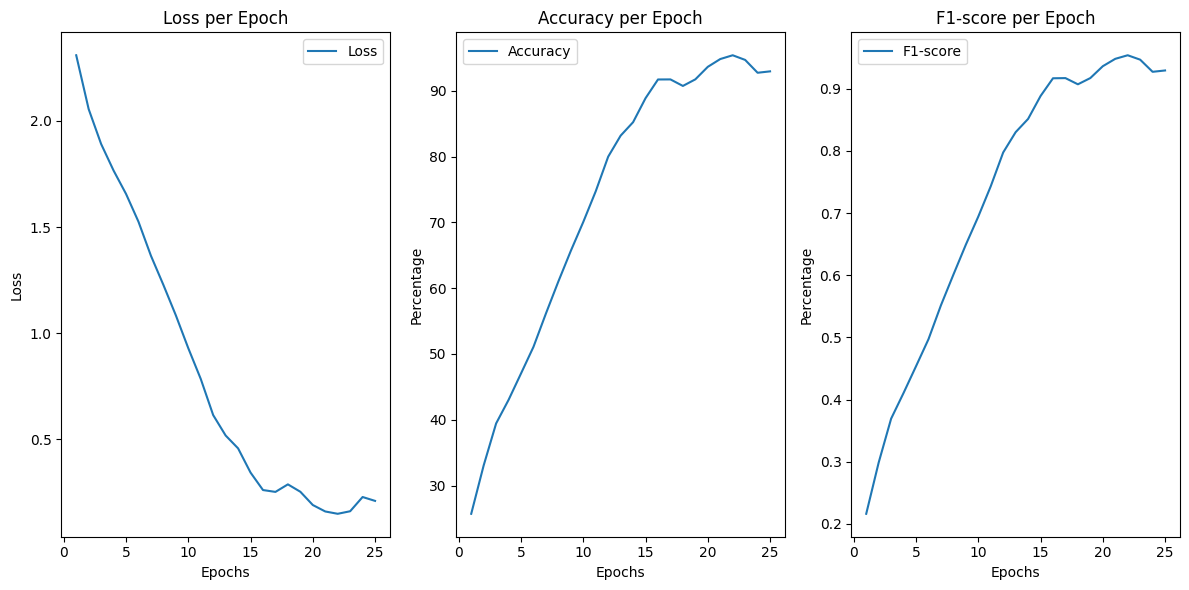

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Путь к датасетам
DATASET_PATH = "/content/human_poses_data"

# 1. Разделение данных
def split_data(
    input_csv=f"{DATASET_PATH}/train_answers_mapped.csv",
    train_csv=f"{DATASET_PATH}/train_split.csv",
    test_csv=f"{DATASET_PATH}/test_split.csv",
):
    annotations = pd.read_csv(input_csv)
    train_data, test_data = train_test_split(
        annotations, test_size=0.2, random_state=42
    )
    train_data.to_csv(train_csv, index=False)
    test_data.to_csv(test_csv, index=False)
    print(f"Данные разделены: {train_csv} для тренировки, {test_csv} для теста.")


# 2. Датасет
class HumanActivityDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = f"{self.annotations.iloc[idx, 0]}.jpg"
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = int(self.annotations.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label


# 3. Трансформации
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


# 4. Архитектура модели
class CustomNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomNet, self).__init__()

        def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU6(inplace=True),
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU6(inplace=True)
            )

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            depthwise_separable_conv(32, 64),
            depthwise_separable_conv(64, 128, stride=2),
            depthwise_separable_conv(128, 128),
            depthwise_separable_conv(128, 256, stride=2),
            depthwise_separable_conv(256, 256),
            depthwise_separable_conv(256, 512, stride=2),
            *[depthwise_separable_conv(512, 512) for _ in range(5)],
            depthwise_separable_conv(512, 1024, stride=2),
            depthwise_separable_conv(1024, 1024),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# 5. Функция потерь и оптимизатор
num_classes = pd.read_csv(f"{DATASET_PATH}/train_answers_mapped.csv")["target_feature"].nunique()
model = CustomNet(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Устройство для вычислений
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)


# 6. Обучение
def train(model, dataloader, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    train_acc_history = []
    train_f1_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * (
            sum([p == l for p, l in zip(all_predictions, all_labels)]) / len(all_labels)
        )
        epoch_f1 = f1_score(all_labels, all_predictions, average="weighted")

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        train_f1_history.append(epoch_f1)

        print(
            f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, F1-score: {epoch_f1:.4f}"
        )

    return train_loss_history, train_acc_history, train_f1_history


# 7. Оценка
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    acc = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    print(f"Accuracy: {acc:.2f}%, F1-score: {f1:.4f}")


# 8. Сохранение предсказаний
def save_predictions(model, dataloader, output_csv=f"{DATASET_PATH}/test_answers.csv"):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    test_data = pd.read_csv(f"{DATASET_PATH}/test_split.csv")
    test_data["predicted_feature"] = predictions
    test_data.to_csv(output_csv, index=False)
    print(f"Предсказания сохранены в {output_csv}")


# 9. Основной процесс
def main():
    # Разделение данных
    split_data()

    # Загрузка данных
    train_dataset = HumanActivityDataset(
        csv_file=f"{DATASET_PATH}/train_split.csv",
        root_dir=f"{DATASET_PATH}/img_train",
        transform=transform
    )
    test_dataset = HumanActivityDataset(
        csv_file=f"{DATASET_PATH}/test_split.csv",
        root_dir=f"{DATASET_PATH}/img_train",
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Обучение
    print("Starting Training...")
    train_loss_history, train_acc_history, train_f1_history = train(
        model, train_loader, criterion, optimizer, num_epochs=25
    )

    # Оценка
    print("Evaluating Model...")
    evaluate(model, test_loader)

    # Сохранение предсказаний
    save_predictions(model, test_loader)

    # Построение графиков
    epochs = range(1, len(train_loss_history) + 1)
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss_history, label="Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc_history, label="Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Percentage")
    plt.legend()

    # F1-score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1_history, label="F1-score")
    plt.title("F1-score per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Percentage")
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


In [ ]:
2 модель

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score
import numpy as np

# Гиперпараметры
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_WORKERS = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Аугментация
transform_train = A.Compose([
    A.Resize(224, 224),
    A.RandomResizedCrop(224, 224, scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    A.GaussianBlur(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

transform_val_test = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Модификация Dataset для использования albumentations
class CustomDataset(Dataset):
    def __init__(self, img_dir, annotations, transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        if not img_name.endswith(".jpg"):
            img_name += ".jpg"
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = self.annotations.iloc[idx, 1]

        if self.transform:
            image = np.array(image)
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, label

# Кастомная архитектура модели
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 28 * 28, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomCNN(num_classes=NUM_CLASSES).to(DEVICE)

# Label Smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

criterion = LabelSmoothingLoss(classes=NUM_CLASSES, smoothing=0.1)

# Оптимизатор и scheduler
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Тренировка
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="macro")
    return total_loss / len(loader), f1

# Валидация
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="macro")
    return total_loss / len(loader), f1

# Основной цикл
best_f1 = 0
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_f1 = validate(model, val_loader, criterion)

    scheduler.step()

    print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model")


In [ ]:
3 модель

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Путь к датасетам
DATASET_PATH = "/content/human_poses_data"

# 1. Разделение данных
def split_data(
    input_csv=f"{DATASET_PATH}/train_answers_mapped.csv",
    train_csv=f"{DATASET_PATH}/train_split.csv",
    test_csv=f"{DATASET_PATH}/test_split.csv",
):
    annotations = pd.read_csv(input_csv)
    train_data, test_data = train_test_split(
        annotations, test_size=0.2, random_state=42
    )
    train_data.to_csv(train_csv, index=False)
    test_data.to_csv(test_csv, index=False)
    print(f"Данные разделены: {train_csv} для тренировки, {test_csv} для теста.")


# 2. Датасет
class HumanActivityDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = f"{self.annotations.iloc[idx, 0]}.jpg"
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = int(self.annotations.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label


# 3. Трансформации
transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


# 4. Архитектура модели
class CustomNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomNet, self).__init__()

        def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU6(inplace=True),
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU6(inplace=True)
            )

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            depthwise_separable_conv(32, 64),
            depthwise_separable_conv(64, 128, stride=2),
            depthwise_separable_conv(128, 128),
            depthwise_separable_conv(128, 256, stride=2),
            depthwise_separable_conv(256, 256),
            depthwise_separable_conv(256, 512, stride=2),
            *[depthwise_separable_conv(512, 512) for _ in range(5)],
            depthwise_separable_conv(512, 1024, stride=2),
            depthwise_separable_conv(1024, 1024),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# 5. Функция потерь и оптимизатор
num_classes = pd.read_csv(f"{DATASET_PATH}/train_answers_mapped.csv")["target_feature"].nunique()

# Рассчет весов классов
labels = pd.read_csv(f"{DATASET_PATH}/train_answers_mapped.csv")["target_feature"].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

model = CustomNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Используем взвешенную функцию потерь
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Добавляем scheduler для обучения

# Устройство для вычислений
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)


# 6. Обучение
def train(model, dataloader, criterion, optimizer, scheduler, num_epochs=10):
    train_loss_history = []
    train_acc_history = []
    train_f1_history = []
    best_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        scheduler.step()  # Обновляем learning rate

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * (
            sum([p == l for p, l in zip(all_predictions, all_labels)]) / len(all_labels)
        )
        epoch_f1 = f1_score(all_labels, all_predictions, average="weighted")

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        train_f1_history.append(epoch_f1)

        print(
            f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, F1-score: {epoch_f1:.4f}"
        )

        # Сохраняем лучшую модель по F1-score
        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            torch.save(model.state_dict(), "best_model.pth")

    return train_loss_history, train_acc_history, train_f1_history


# 7. Оценка
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    acc = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    print(f"Accuracy: {acc:.2f}%, F1-score: {f1:.4f}")


# 8. Основной процесс
def main():
    # Разделение данных
    split_data()

    # Загрузка данных
    train_dataset = HumanActivityDataset(
        csv_file=f"{DATASET_PATH}/train_split.csv",
        root_dir=f"{DATASET_PATH}/img_train",
        transform=transform
    )
    test_dataset = HumanActivityDataset(
        csv_file=f"{DATASET_PATH}/test_split.csv",
        root_dir=f"{DATASET_PATH}/img_train",
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Обучение
    print("Starting Training...")
    train_loss_history, train_acc_history, train_f1_history = train(
        model, train_loader, criterion, optimizer, scheduler, num_epochs=25
    )

    # Оценка
    print("Evaluating Model...")
    evaluate(model, test_loader)


if __name__ == "__main__":
    main()
